Segmentation RFM (Récence, Fréquence, Valeur Monétaire), nous devons d'abord calculer les métriques RFM pour chaque utilisateur, puis les classer en segments.

### Étapes pour appliquer la méthode RFM :
1. **Récence (Recency)** : Nombre de jours depuis la dernière interaction ou achat.
2. **Fréquence (Frequency)** : Nombre de fois qu'un utilisateur a interagi ou acheté.
3. **Valeur Monétaire (Monetary Value)** : Montant total dépensé par l'utilisateur.

### Calcul des Scores RFM :
1. **Récence** : Utiliser la colonne `days_since_last_purchase`.
2. **Fréquence** : Utiliser les colonnes de fréquence des interactions (`number_of_sessions_2m`, `number_of_sessions_5m`, etc.).
3. **Valeur Monétaire** : Utiliser `total_purchase_value`.


In [1]:
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
import requests
import io
from urllib.parse import urljoin

In [2]:
# URL directe vers le fichier Parquet sur GitHub
base_url = "https://github.com/EricIrjam/e-amazing/raw/main/data/user_stats_df_output.parquet/"



In [3]:
# Fonction pour récupérer et lire tous les fichiers .parquet dans le répertoire
def read_parquet_files(base_url):
    # Les fichiers que nous devons récupérer
    file_names = [
        f"part-0000{i}-9b319896-debc-49c4-b0a7-fbbd59863d51-c000.snappy.parquet" for i in range(5)
    ]

    # Lire et combiner tous les fichiers Parquet en un seul DataFrame
    tables = []
    for file_name in file_names:
        file_url = urljoin(base_url, file_name)
        response = requests.get(file_url)
        response.raise_for_status()

        # Lire le fichier Parquet
        table = pq.read_table(io.BytesIO(response.content))
        tables.append(table)

    # Combiner toutes les tables en une seule
    combined_table = pa.concat_tables(tables)
    return combined_table.to_pandas()

In [4]:
df = read_parquet_files(base_url)

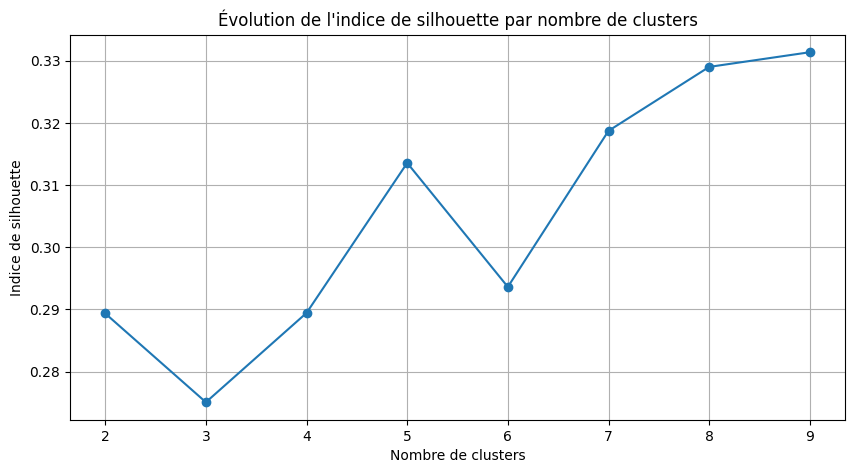

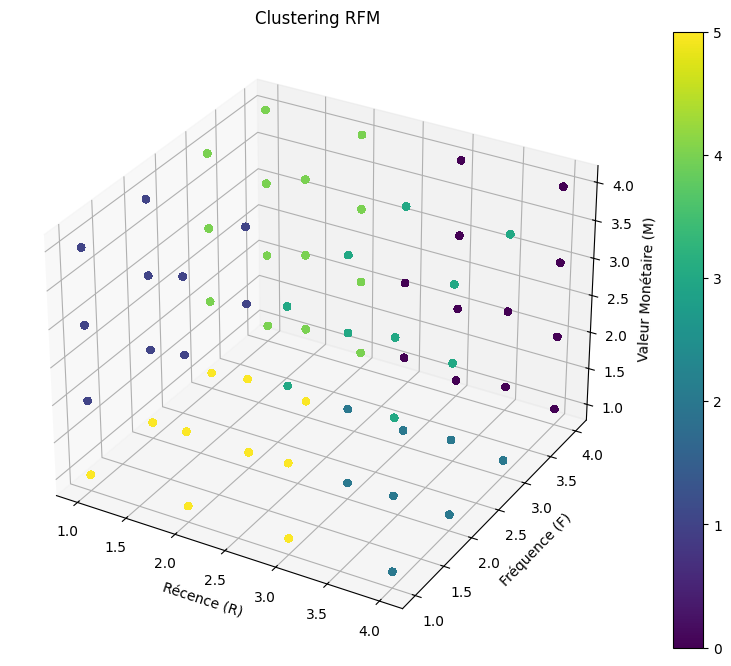

In [5]:

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

# Calcul des scores RFM
# Recency : on utilise la colonne 'days_since_last_purchase' (moins c'est élevé, mieux c'est)
df['R_Score'] = pd.qcut(df['days_since_last_purchase'], q=4, labels=[4, 3, 2, 1])

# Frequency : on utilise les sessions des 7 derniers mois (plus c'est élevé, mieux c'est)
df['F_Score'] = pd.qcut(df['number_of_sessions_7m'], q=4, labels=[1, 2, 3, 4])

# Monetary Value : on utilise la colonne 'total_purchase_value' (plus c'est élevé, mieux c'est)
df['M_Score'] = pd.qcut(df['total_purchase_value'], q=4, labels=[1, 2, 3, 4])

# Préparation des données pour le clustering
X = df[['R_Score', 'F_Score', 'M_Score']].astype(int)

# Calcul de l'indice de silhouette pour différents nombres de clusters
silhouette_scores = []
range_n_clusters = range(2, 10)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Graphique de l'évolution de l'indice de silhouette
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Évolution de l'indice de silhouette par nombre de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Indice de silhouette")
plt.grid(True)
plt.show()

# Clustering avec le nombre optimal de clusters trouvé (exemple : 6 clusters)
optimal_clusters = 6
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Graphique 3D du clustering
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['R_Score'], df['F_Score'], df['M_Score'], c=df['cluster'], cmap='viridis')

# Titres et labels
ax.set_title('Clustering RFM')
ax.set_xlabel('Récence (R)')
ax.set_ylabel('Fréquence (F)')
ax.set_zlabel('Valeur Monétaire (M)')
plt.colorbar(scatter)
plt.show()


### Explications : **A voir pour l'interprétation :**
- **Recency Score (`R_Score`)** : Les utilisateurs sont divisés en 4 groupes selon la récence de leur dernière interaction. Le groupe avec les valeurs les plus faibles (récence faible) reçoit le score le plus élevé.
- **Frequency Score (`F_Score`)** : Les utilisateurs sont segmentés selon le nombre de sessions sur les 7 derniers mois.
- **Monetary Score (`M_Score`)** : Les utilisateurs sont classés selon la valeur totale des achats.
- **Segmentation (`RFM_Segment`)** : Les scores combinés sont utilisés pour segmenter les utilisateurs en groupes comme "Champions", "Loyal", "Potentiels", etc. `en fonction du nombre de clusters apparent.`

In [ ]:
# Importation des bibliothèques nécessaires
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

# Chargement du jeu de données
df = pd.read_parquet("data/user_stats_df_output.parquet")

# Calcul des scores RFM
# Recency : on utilise la colonne 'days_since_last_purchase' (moins c'est élevé, mieux c'est)
df['R_Score'] = pd.qcut(df['days_since_last_purchase'], q=4, labels=[4, 3, 2, 1])

# Frequency : on utilise les sessions des 7 derniers mois (plus c'est élevé, mieux c'est)
df['F_Score'] = pd.qcut(df['number_of_sessions_7m'], q=4, labels=[1, 2, 3, 4])

# Monetary Value : on utilise la colonne 'total_purchase_value' (plus c'est élevé, mieux c'est)
df['M_Score'] = pd.qcut(df['total_purchase_value'], q=4, labels=[1, 2, 3, 4])

# Préparation des données pour le clustering
X = df[['R_Score', 'F_Score', 'M_Score']].astype(int)

# Standardisation des données RFM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calcul de l'indice de silhouette pour différents nombres de clusters
silhouette_scores = []
range_n_clusters = range(2, 10)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Graphique de l'évolution de l'indice de silhouette
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Évolution de l'indice de silhouette par nombre de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Indice de silhouette")
plt.grid(True)
plt.show()

# Clustering avec le nombre optimal de clusters trouvé (exemple : 6 clusters)
optimal_clusters = 6
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Graphique 3D du clustering RFM
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['R_Score'], df['F_Score'], df['M_Score'], c=df['Cluster'], cmap='viridis')

# Titres et labels
ax.set_title('Clustering RFM')
ax.set_xlabel('Récence (R)')
ax.set_ylabel('Fréquence (F)')
ax.set_zlabel('Valeur Monétaire (M)')
plt.colorbar(scatter)
plt.show()

# Séparation des données et de la cible pour le modèle de classification
X = df[['R_Score', 'F_Score', 'M_Score']]  # Caractéristiques RFM
y = df['Cluster']  # Cible : cluster attribué

# Division des données en ensembles d'entraînement et de test
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle Decision Tree
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(data_train, target_train)

# Prédiction sur l'ensemble de test
predictions = tree.predict(data_test)

# Évaluation du modèle
accuracy = accuracy_score(target_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Afficher le rapport de classification et la matrice de confusion
print("\nClassification Report:")
print(classification_report(target_test, predictions))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(target_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()


In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

Accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.68      0.81      2747
           1       1.00      0.76      0.87      2361
           2       0.66      1.00      0.80      2625
           3       0.84      1.00      0.91      2321
           4       1.00      0.91      0.95      3931
           5       0.70      0.70      0.70      2988

    accuracy                           0.84     16973
   macro avg       0.87      0.84      0.84     16973
weighted avg       0.87      0.84      0.84     16973


Confusion Matrix:


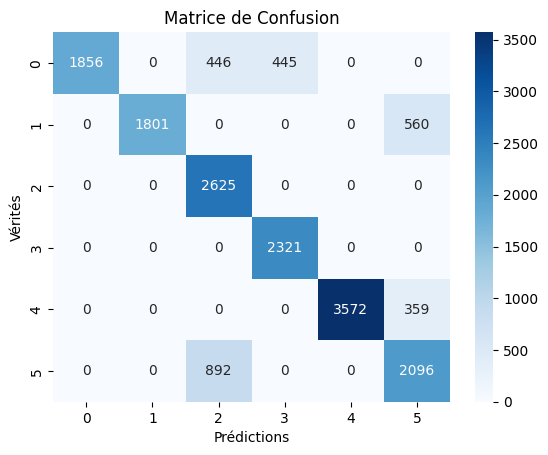

In [9]:
# Séparation des données et de la cible pour le modèle de classification
X = df[['R_Score', 'F_Score', 'M_Score']]  # Caractéristiques RFM
y = df['cluster']  # Cible : cluster attribué

# Division des données en ensembles d'entraînement et de test
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle Decision Tree
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(data_train, target_train)

# Prédiction sur l'ensemble de test
predictions = tree.predict(data_test)

# Évaluation du modèle
accuracy = accuracy_score(target_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Afficher le rapport de classification et la matrice de confusion
print("\nClassification Report:")
print(classification_report(target_test, predictions))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(target_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()

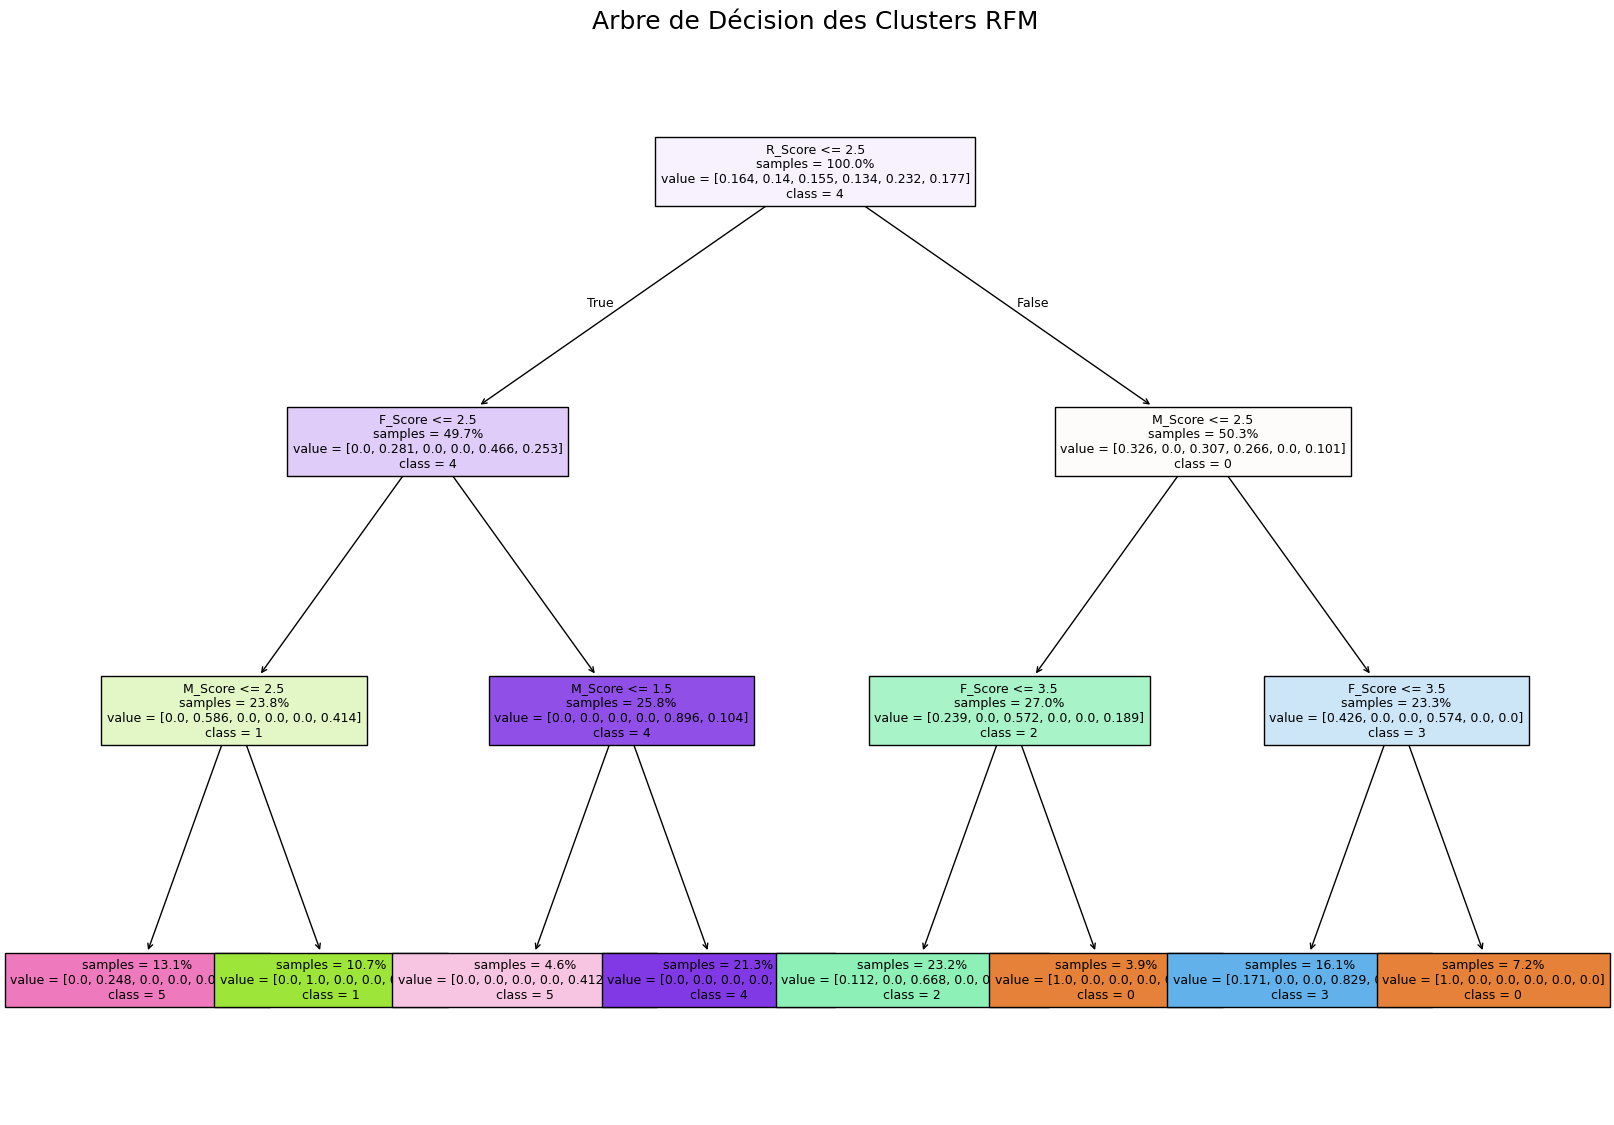

In [15]:
from sklearn.tree import plot_tree

# Définir les noms des features et des classes pour l'affichage de l'arbre
feature_names = ['R_Score', 'F_Score', 'M_Score']
class_names = [str(cls) for cls in tree.classes_]  # Convertir les classes en chaînes de caractères

# Visualisation de l'arbre de décision avec une taille de figure ajustée
# Visualisation de l'arbre de décision avec des ajustements pour une meilleure lisibilité
_, ax = plt.subplots(figsize=(20, 14), dpi=100)  # Augmentation de la taille et de la résolution de la figure
plot_tree(
    tree,
    feature_names=feature_names,
    class_names=class_names,
    impurity=False,
    filled=True,
    ax=ax,
    fontsize=9,  # Ajustement de la taille de police pour une meilleure gestion des niveaux inférieurs
    proportion=True  # Affiche les proportions pour des valeurs plus compactes
)

plt.title('Arbre de Décision des Clusters RFM', fontsize=18)
plt.show()



